In [210]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Funciones auxiliares

In [211]:
from graphviz import Digraph
import re

# Draw a compute grap of a node and its children

def get_variable_name(value, namespace):
    for name, val in namespace.items():
        if val is value:
            if re.match(r"^_+[0-9]*", name):
                continue
            return name
    return None

def trace(root, namespace):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      node_name = get_variable_name(v, namespace)
      v.label = node_name
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root, namespace):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root, namespace)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

# Crear un objeto capaz de guardar su derivada

In [212]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out
  
  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  
  def __rmul__(self, other):
    return self * other
  
  def __truediv__(self, other):
    return self * (other ** -1)
  
  def __rtruediv__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    return other * (self ** -1)
  
  def __neg__(self):
    return self * -1
  
  def __sub__(self, other):
    return self + (-other)
  
  def __rsub__(self, other):
    return other + (-self)
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** other, (self,), f'**{other}')

    def _backward():
      self.grad += (other * self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out
  
  def exp(self):
    out = Value(math.exp(self.data), (self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out
  
  def tanh(self):
    out = Value(math.tanh(self.data), (self,), 'tanh')

    def _backward():
      self.grad += (1 - out.data ** 2) * out.grad
    out._backward = _backward
    return out
  
  def backward(self):
    topo = []
    visited = set()
    def topological_sort(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          topological_sort(child)
        topo.append(v)

    topological_sort(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

### Ejemplos de operaciones simples y sus derivadas

In [223]:
# Multiplication
a = Value(3)
b = 2 * a

b.backward()
print(f"If b=2a then db/da should be 2, actual: {a.grad}")

# Sum
a = Value(3)
b = 2 + a

b.backward()
print(f"If b=2+a then db/da should be 1, actual: {a.grad}")

# division
a = Value(3)
b = 15/a

b.backward()
print(f"If b=15/a then db/da should be 15*(-1/9)=-1.666..., actual: {a.grad}")

# constant power
a = Value(3)
b = a**2

b.backward()
print(f"If b=a**2 then db/da should be 6, actual: {a.grad}")

If b=2a then db/da should be 2, actual: 2.0
If b=2+a then db/da should be 1, actual: 1.0
If b=15/a then db/da should be 15*(-1/9)=-1.666..., actual: -1.6666666666666665
If b=a**2 then db/da should be 6, actual: 6.0


# Crear un red neuronal simple

### Definir una neurona

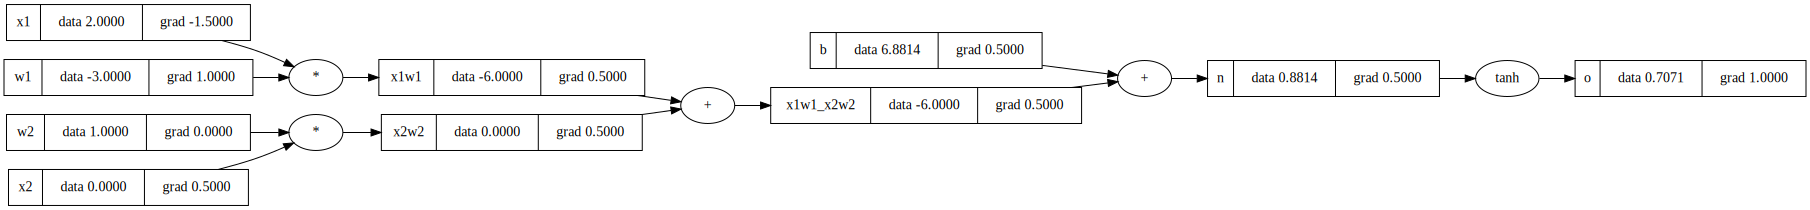

In [224]:
# Neuron with an input of 2 dimensionsd and a tanh activation

x1 = Value(2.0)
x2 = Value(0.0)
w1 = Value(-3.0)
w2 = Value(1.0)
b = Value(6.8813735870195432)
x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1_x2w2 = x1w1 + x2w2
n = x1w1_x2w2 + b
o = n.tanh()

o.backward()

draw_dot(o, locals())

## Comparar resultados al definir tanh directamente

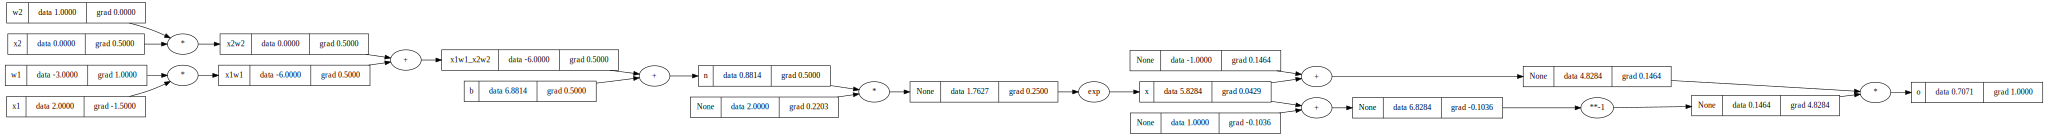

In [119]:
x1 = Value(2.0)
x2 = Value(0.0)
w1 = Value(-3.0)
w2 = Value(1.0)
b = Value(6.8813735870195432)
x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1_x2w2 = x1w1 + x2w2
n = x1w1_x2w2 + b
x = (n * 2).exp()
o = (x - 1) / (x + 1)

o.backward()

draw_dot(o, locals())

### Comparar resultados con Pytorch

In [238]:
import torch

x1 = torch.tensor(2.0, requires_grad=True)
x2 = torch.tensor(0.0, requires_grad=True)
w1 = torch.tensor(-3.0, requires_grad=True)
w2 = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(6.8813735870195432, requires_grad=True)
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())
print('b', b.grad.item())

0.7071067094802856
---
x1 -1.5000003576278687
x2 0.5000001192092896
w1 1.000000238418579
w2 0.0
b 0.5000001192092896


# Entrenando una red neuronal simple

In [239]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))

    def __call__(self, x):
        output = sum(w * x for w, x in zip(self.w, x)) + self.b
        return output.tanh()
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs =  [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:

    def __init__(self, nin, nouts: list[int]):
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[i], sizes[i + 1]) for i in  range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)     
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

### Ejemplo de red neuronal con 2 capas ocultas

In [240]:
x = [2.0, 3.0, -1.0]
nn = MLP(len(x), [4, 4, 1])
output = nn(x)

In [241]:
print(f"Total number of parameters: {len(nn.parameters())}")

Total number of parameters: 41


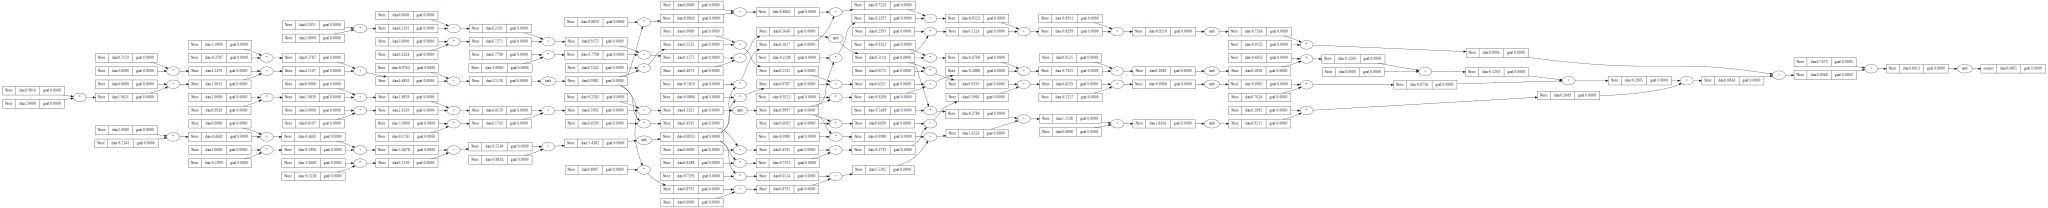

In [242]:
# Neural net compute graph
draw_dot(output, locals())

### Definir el loss

In [243]:
mse_loss = lambda y, y_pred: sum([(yt - yp)**2 for yt, yp in zip(y, y_pred)]) / len(y)

### Pasar un bacth de datos

In [244]:
# Pass a batch not just one input
X = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

y = [1.0, -1.0, -1.0, 1.0]

In [245]:
# Calculate the loss for the predictions with the ramdomly initialized weights
preds = [nn(x) for x in X]
loss = mse_loss(y, preds)
loss

Value(data=1.4677679398992416)

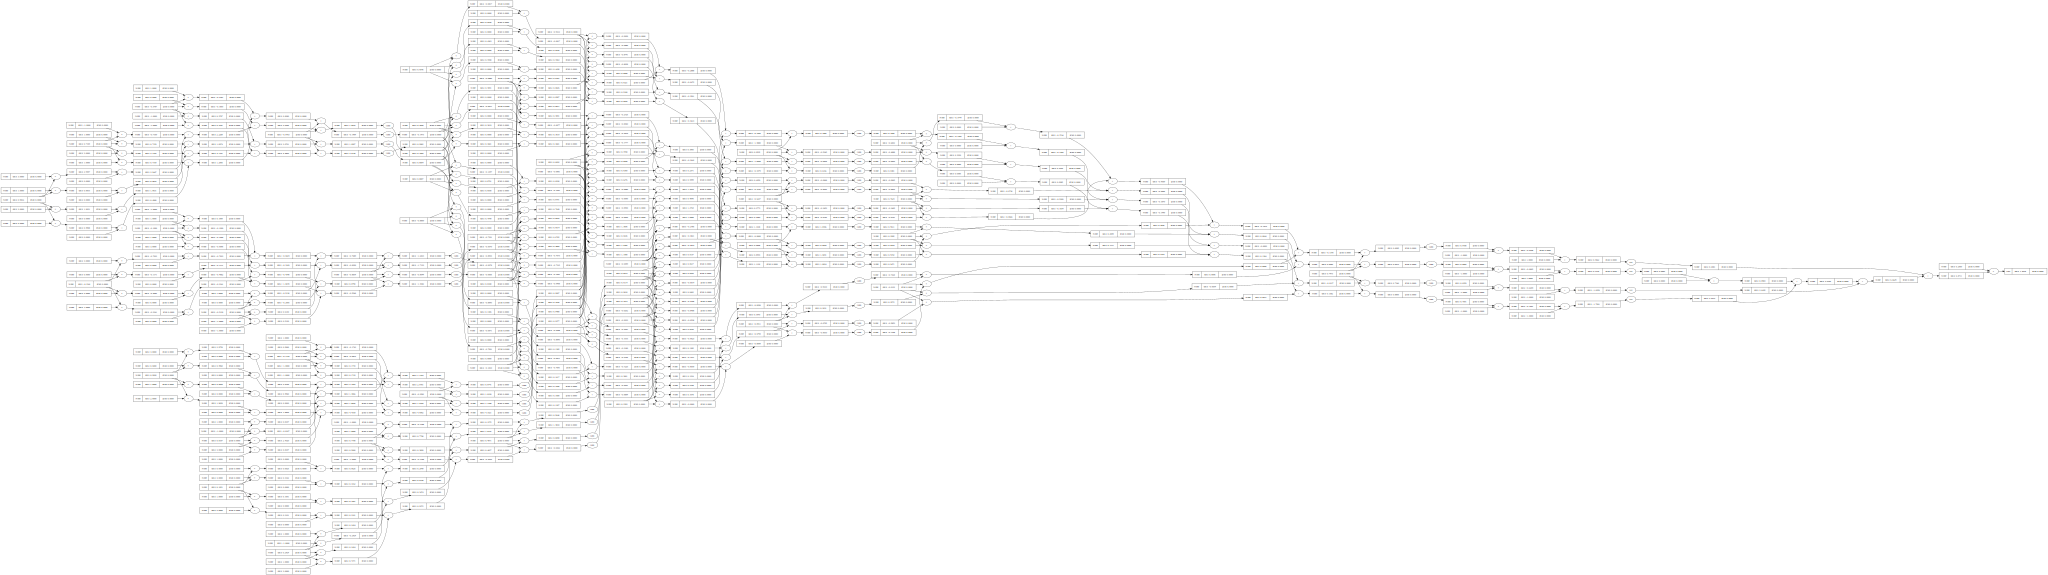

In [246]:
# Complete compute the graph for the neural net with a batch of 4 and an MSE loss
draw_dot(loss, locals())

### Entrenamiento de la red

In [247]:
learning_rate = 0.05
epochs = 20


for epoch in range(epochs):
    # Calculate the loss
    loss = mse_loss(y, [nn(x) for x in X])

    # Reset the grads
    for p in nn.parameters():
        p.grad = 0.0

    # Calculate the grads
    loss.backward()

    # Gradient descent
    for p in nn.parameters():
        p.data -= learning_rate * p.grad

    print(f"epoch: {epoch} - loss: {loss.data}")

epoch: 0 - loss: 1.4677679398992416
epoch: 1 - loss: 1.3379544714654465
epoch: 2 - loss: 1.1850206784216295
epoch: 3 - loss: 1.030144133230679
epoch: 4 - loss: 0.8975675224583861
epoch: 5 - loss: 0.7914434562683315
epoch: 6 - loss: 0.7010457889405953
epoch: 7 - loss: 0.617093807242864
epoch: 8 - loss: 0.5352936839375326
epoch: 9 - loss: 0.45540221601674863
epoch: 10 - loss: 0.38065874754284007
epoch: 11 - loss: 0.3155811401035759
epoch: 12 - loss: 0.26252341297211523
epoch: 13 - loss: 0.2207983948685642
epoch: 14 - loss: 0.1882589879495209
epoch: 15 - loss: 0.1626935947831035
epoch: 16 - loss: 0.1423283417200467
epoch: 17 - loss: 0.12585717256179704
epoch: 18 - loss: 0.11234075301098993
epoch: 19 - loss: 0.10110186147571941


In [248]:
print("Predictions:", [nn(x).data for x in X])
print("Labels:", y)

Predictions: [0.8712693304639763, -0.6094058916883778, -0.7155263223722573, 0.6586445298948322]
Labels: [1.0, -1.0, -1.0, 1.0]
